In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
import os

In [2]:
merged_df = pd.read_csv("all_merged_data.csv")

C:\Users\Romina\AppData\Local\Temp\ipykernel_6276\2031766969.py:1: DtypeWarning: Columns (43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,

In [12]:
mapping_df = pd.read_csv("final_merged_protein_organ.csv")
start_prot_idx = merged_df.columns.get_loc("A1BG")
dataset_proteins = set(merged_df.columns[start_prot_idx:]) 
mapped_proteins = set(mapping_df['Protein'])
common_proteins = dataset_proteins.intersection(mapped_proteins)
print(f"Number of common proteins: {len(common_proteins)}")
filtered_mapping_df = mapping_df[mapping_df['Protein'].isin(common_proteins)]
organ_to_proteins = filtered_mapping_df.groupby('Organ')['Protein'].apply(set).to_dict()
protein_count_per_organ = {organ: len(proteins) for organ, proteins in organ_to_proteins.items()}
protein_count_df = pd.DataFrame(list(protein_count_per_organ.items()), columns=["Organ", "Protein Count"])
print(f"Total organs mapped: {len(organ_to_proteins)}")
protein_count_df.head(15)

Number of common proteins: 548
Total organs mapped: 15


,Organ,Protein Count
0,Adipose,3
1,Artery,9
2,Brain,147
3,Esophagus,3
4,Heart,7
5,Immune,95
6,Intestine,36
7,Kidney,8
8,Liver,80
9,Lung,10


In [7]:
protein_start = merged_df.columns.get_loc("A1BG")  
protein_end = merged_df.columns.get_loc("ZPR1") + 1 
protein_columns = merged_df.columns[protein_start:protein_end].tolist()

In [8]:
protein_data = merged_df[protein_columns]

In [10]:
protein_data.head()

,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,ACAA1,ACADM,...,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
0,4.589104e-01,0.049589,-1.816289,-6.315904e-01,-0.692984,-1.153658,-2.081826e-01,-1.700924e+00,-0.365568,-9.285266e-01,...,-1.292154e+00,-0.450031,-1.884634e-01,0.301836,-0.136744,-1.723948e+00,-1.069217,1.512075,-1.092510e+00,9.121869e-01
1,-9.161484e-01,1.804964,1.874766,4.089987e-01,2.375087,0.847455,-1.978955e+00,1.100232e+00,0.658884,-5.376665e-01,...,1.689146e+00,-0.337896,1.010863e+00,-1.086189,-0.489580,2.008019e+00,1.567717,0.000000,-5.385477e-01,-3.585828e-02
2,6.462886e-01,0.593618,0.379084,-9.565613e-01,-1.279487,-0.335910,4.796019e-01,4.516504e-02,-0.628296,3.329085e-01,...,-2.225614e-01,0.123892,-2.329263e-01,-0.695610,0.520704,-1.001482e+00,0.730239,0.646381,1.089124e+00,2.811340e+00
3,-1.031546e+00,0.243267,-0.607625,1.457297e+00,0.077204,0.664712,-1.471190e-01,9.708984e-01,0.336992,2.331016e-17,...,6.083435e-18,0.321668,4.688260e-01,0.000000,0.000000,2.077975e-17,0.000000,1.822812,-1.045976e+00,3.542480e-17
4,9.910041e-18,0.000000,0.513528,5.143565e-18,-0.602953,-0.013944,2.020091e-17,-2.246395e-17,-0.408546,2.331016e-17,...,6.083435e-18,0.000000,-2.029756e-17,0.000000,0.000000,2.077975e-17,0.000000,0.000000,2.374236e-17,3.542480e-17


In [34]:
output_folder = "pc1_loadings"
os.makedirs(output_folder, exist_ok=True)

# Dictionary to store PC1 loadings for each organ
pc1_loadings_dict = {}

for organ, proteins in organ_to_proteins.items():
    
    # Select only proteins that exist in the dataset
    valid_proteins = [p for p in proteins if p in merged_df.columns]  
    X = merged_df[valid_proteins].copy()  

    if len(valid_proteins) == 0:
        print(f"⚠️ No valid proteins found for {organ}, skipping...")
        continue

    # Standardize the protein data (PCA works best on scaled data)
    X = (X - X.mean()) / X.std()

    # Perform PCA
    pca = PCA(n_components=1)
    pca.fit(X)

    # Extract PC1 loadings
    pc1_loadings = pd.DataFrame({
        "Protein": X.columns,
        "Loading": pca.components_[0]  # First principal component loadings
    })

    # Sort by absolute loading values (strongest proteins first)
    pc1_loadings = pc1_loadings.sort_values(by="Loading", ascending=False)

    # Store the result
    pc1_loadings_dict[organ] = pc1_loadings

    # Save the results for each organ
    file_path = os.path.join(output_folder, f"pc1_loadings_{organ}.csv")
    pc1_loadings.to_csv(file_path, index=False)
    print(f"✅ Saved: {file_path}")

# Display one sample organ (e.g., Brain) to confirm results
sample_organ = "Brain"  # Change this to any organ you want to inspect
if sample_organ in pc1_loadings_dict:
    display(pc1_loadings_dict[sample_organ])
else:
    print(f"⚠️ No PC1 loadings found for {sample_organ}")


✅ Saved: pc1_loadings\pc1_loadings_Adipose.csv
✅ Saved: pc1_loadings\pc1_loadings_Artery.csv
✅ Saved: pc1_loadings\pc1_loadings_Brain.csv
✅ Saved: pc1_loadings\pc1_loadings_Esophagus.csv
✅ Saved: pc1_loadings\pc1_loadings_Heart.csv
✅ Saved: pc1_loadings\pc1_loadings_Immune.csv
✅ Saved: pc1_loadings\pc1_loadings_Intestine.csv
✅ Saved: pc1_loadings\pc1_loadings_Kidney.csv
✅ Saved: pc1_loadings\pc1_loadings_Liver.csv
✅ Saved: pc1_loadings\pc1_loadings_Lung.csv
✅ Saved: pc1_loadings\pc1_loadings_Muscle.csv
✅ Saved: pc1_loadings\pc1_loadings_Pancreas.csv
✅ Saved: pc1_loadings\pc1_loadings_Skin.csv
✅ Saved: pc1_loadings\pc1_loadings_Stomach.csv
✅ Saved: pc1_loadings\pc1_loadings_Whole Blood.csv


,Protein,Loading
43,SEZ6L,0.197666
70,MOG,0.189451
72,RTBDN,0.183404
143,SLITRK1,0.181964
56,BCAN,0.178417
...,...,...
102,LHPP,0.009487
51,RGS8,0.008075
40,AMBN,0.007119
21,POMC,0.003681


In [35]:
pc1_loadings.to_csv(f"pc1_loadings_{organ}.csv", index=False)

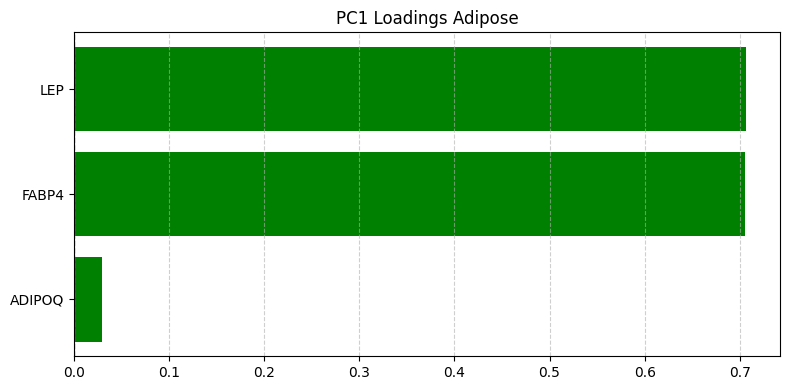

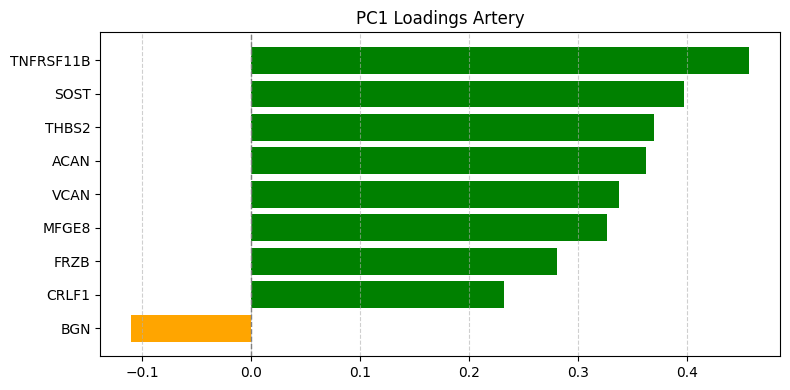

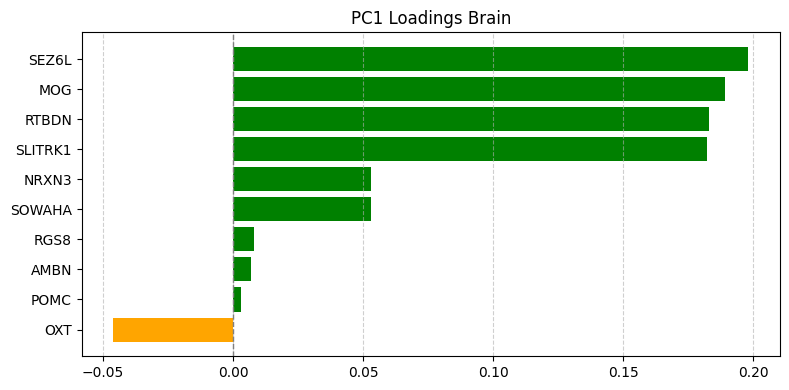

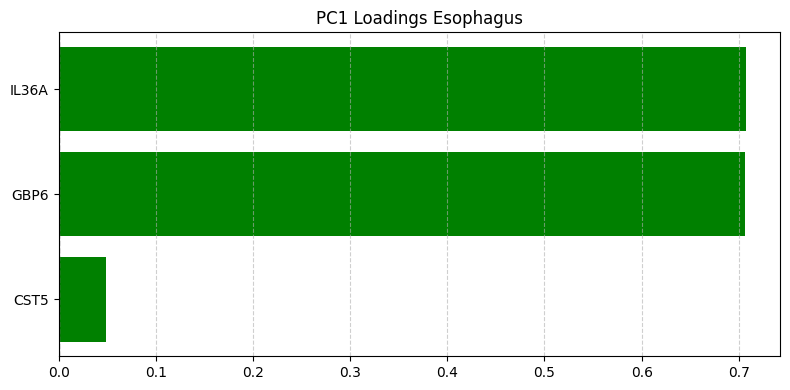

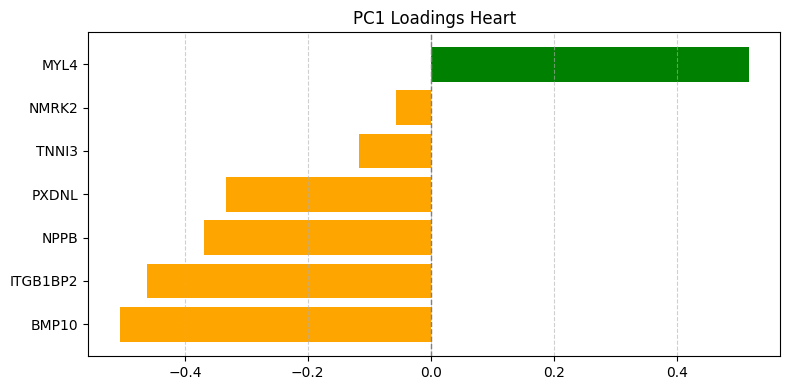

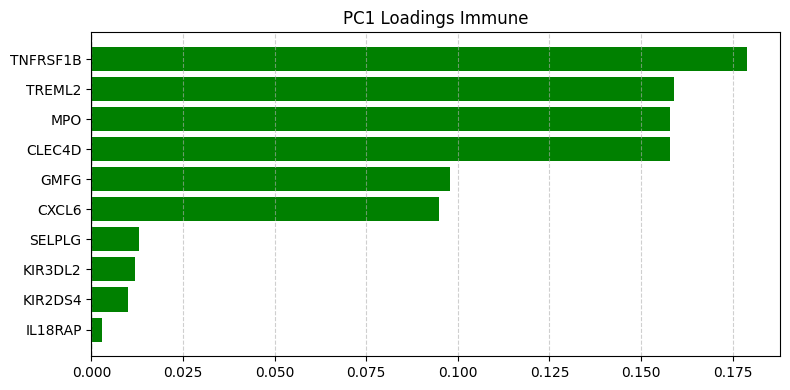

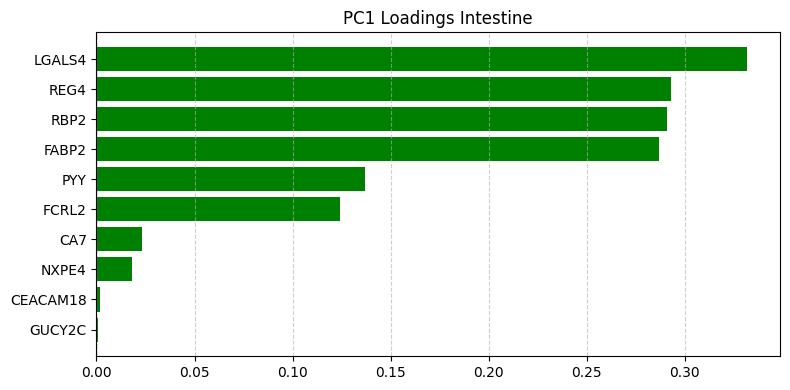

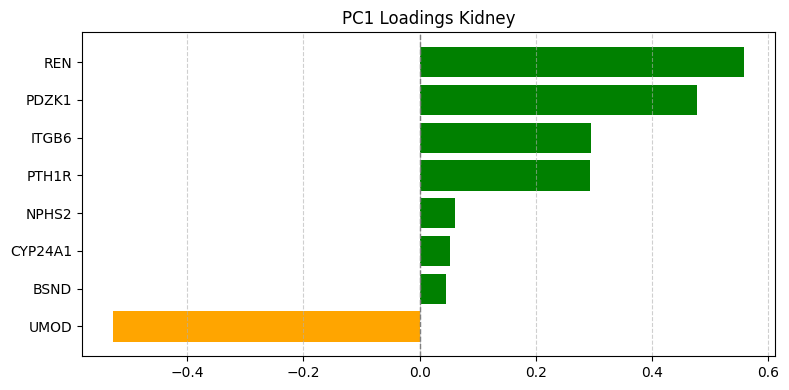

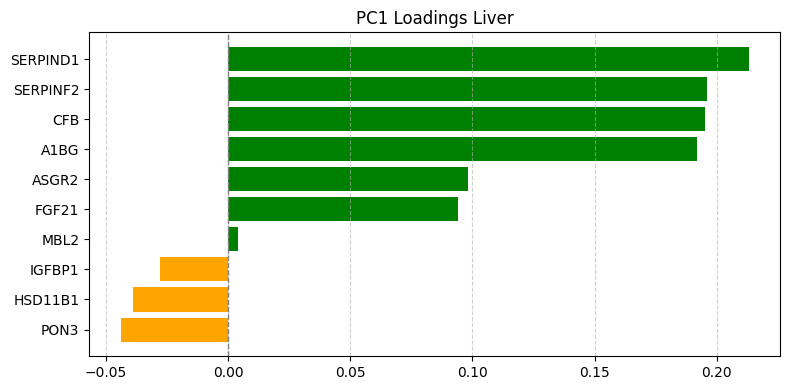

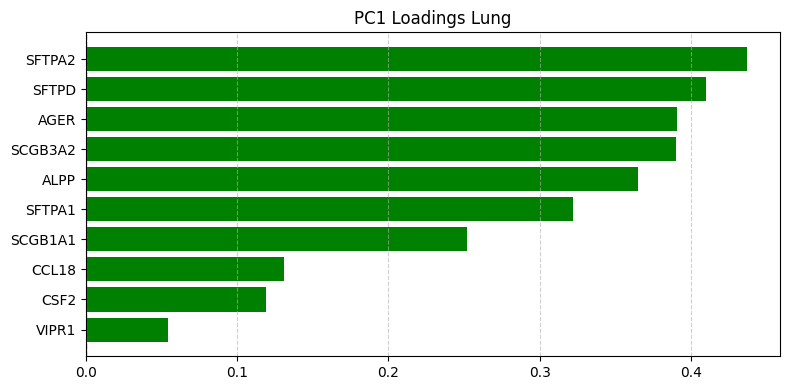

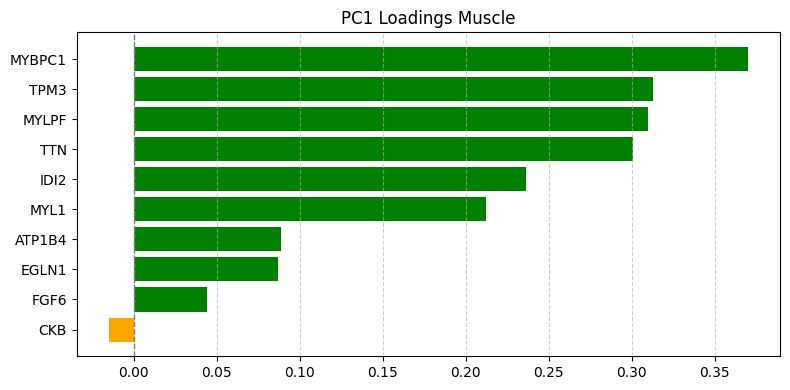

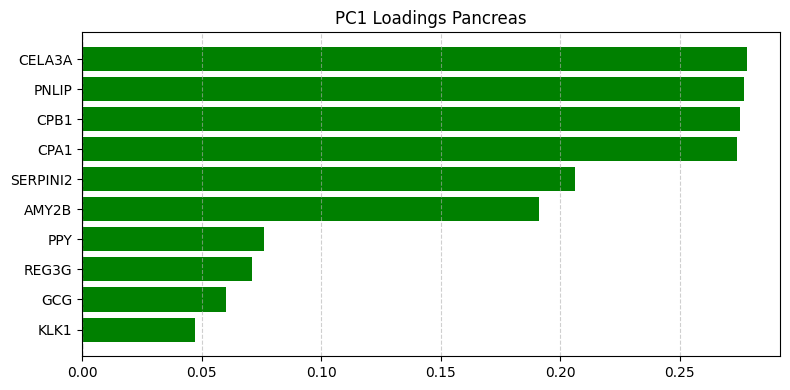

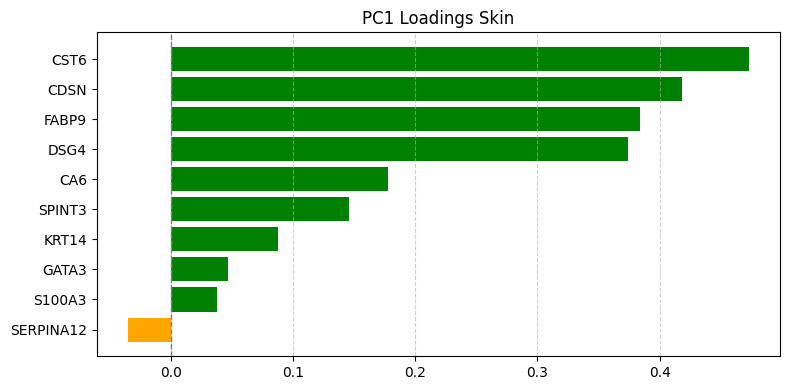

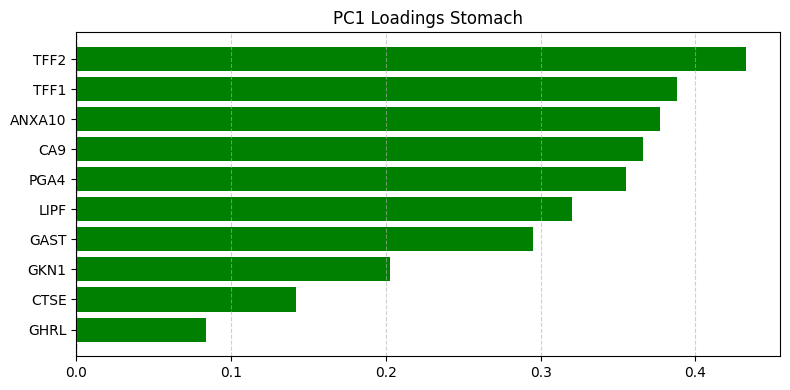

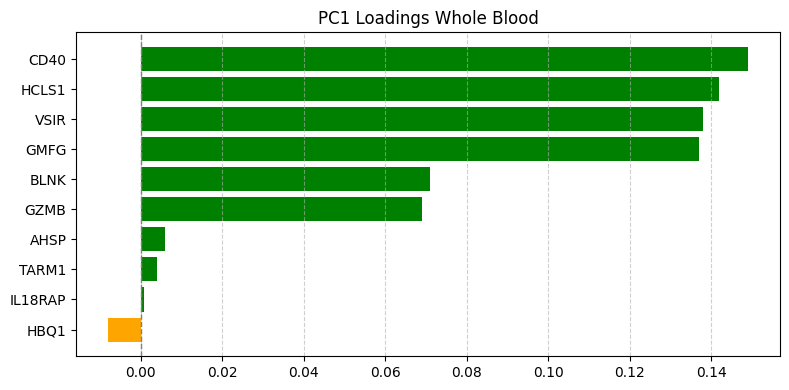

In [ ]:
pc1_loadings_dict = {
    "Adipose": {"LEP": 0.707, "FABP4": 0.706, "ADIPOQ": 0.029},
    "Artery": {"TNFRSF11B": 0.457, "SOST": 0.397, "THBS2": 0.370, "ACAN": 0.362, "VCAN": 0.338, "MFGE8": 0.327, "FRZB": 0.281, "CRLF1": 0.232, "BGN": -0.110},
    "Brain": {"SEZ6L": 0.198, "MOG": 0.189, "RTBDN": 0.183, "SLITRK1": 0.182, "SOWAHA": 0.053, "NRXN3": 0.0531, "RGS8": 0.008, "AMBN": 0.007, "POMC": 0.003, "OXT": -0.046},
    "Esophagus": {"IL36A": 0.707, "GBP6": 0.706, "CST5": 0.049},
    "Heart": {"MYL4": 0.517, "NMRK2": -0.057, "TNNI3": -0.117, "PXDNL": -0.333, "NPPB": -0.369, "ITGB1BP2": -0.461, "BMP10": -0.506},
    "Immune": {"TNFRSF1B": 0.179, "TREML2": 0.159, "MPO": 0.158, "CLEC4D": 0.158, "GMFG": 0.098, "CXCL6": 0.095, "SELPLG": 0.013, "KIR3DL2": 0.012, "KIR2DS4": 0.010, "IL18RAP": 0.003 },
    "Intestine": {"LGALS4": 0.332, "REG4": 0.293, "RBP2": 0.291, "FABP2": 0.287, "PYY": 0.137, "FCRL2": 0.124, "CA7": 0.023, "NXPE4": 0.018, "CEACAM18": 0.002, "GUCY2C": 0.001},
    "Kidney": {"REN": 0.558, "PDZK1": 0.478, "ITGB6": 0.295, "PTH1R": 0.293, "NPHS2": 0.061, "CYP24A1": 0.053, "BSND": 0.046, "UMOD": -0.527},
    "Liver": {"SERPIND1": 0.213, "SERPINF2": 0.196, "CFB": 0.195, "A1BG": 0.192, "ASGR2": 0.098, "FGF21": 0.094, "MBL2": 0.004, "IGFBP1": -0.028, "HSD11B1": -0.039, "PON3": -0.044},
    "Lung": {"SFTPA2": 0.437, "SFTPD": 0.410, "AGER": 0.391, "SCGB3A2": 0.390, "ALPP": 0.365, "SFTPA1": 0.322, "SCGB1A1": 0.252, "CCL18": 0.131, "CSF2": 0.119, "VIPR1": 0.054},
    "Muscle": {"MYBPC1": 0.370, "TPM3": 0.313, "MYLPF": 0.310, "TTN": 0.301, "IDI2": 0.236, "MYL1": 0.212, "ATP1B4": 0.089, "EGLN1": 0.087, "FGF6": 0.044, "CKB": -0.015},
    "Pancreas": {"CELA3A": 0.278, "PNLIP": 0.277, "CPB1": 0.275, "CPA1": 0.274, "SERPINI2": 0.206, "AMY2B": 0.191, "PPY": 0.076, "REG3G": 0.071, "GCG": 0.060, "KLK1": 0.047},
    "Skin": {"CST6": 0.473, "CDSN": 0.418, "FABP9": 0.384, "DSG4": 0.374, "CA6": 0.178, "SPINT3": 0.146, "KRT14": 0.088, "GATA3": 0.047, "S100A3": 0.038, "SERPINA12": -0.035},
    "Stomach": {"TFF2": 0.433, "TFF1": 0.388, "ANXA10": 0.377, "CA9": 0.366, "PGA4": 0.355, "LIPF": 0.320, "GAST": 0.295, "GKN1": 0.203, "CTSE": 0.142, "GHRL": 0.084},
    "Whole Blood": {"CD40": 0.149, "HCLS1": 0.142, "VSIR": 0.138, "GMFG": 0.137, "BLNK": 0.071, "GZMB": 0.069, "AHSP": 0.006, "TARM1": 0.004, "IL18RAP": 0.0009, "HBQ1": -0.008},
}
  

for organ, proteins in pc1_loadings_dict.items():
    df = pd.DataFrame(proteins.items(), columns=["Protein", "PC1 Loading"]).sort_values(by="PC1 Loading", ascending=False)
    colors = ['green' if x >= 0 else 'orange' for x in df["PC1 Loading"]]

    plt.figure(figsize=(8, 4))  
    plt.barh(df["Protein"], df["PC1 Loading"], color=colors) 

    plt.title(f"PC1 Loadings {organ}")
    plt.axvline(0, color='gray', linestyle='dashed', linewidth=1) 
    plt.grid(axis="x", linestyle="--", alpha=0.6)  
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pc1_variance_explained = {}

for organ, proteins in organ_to_proteins.items():
    valid_proteins = [protein for protein in proteins if protein in merged_df.columns]  

    organ_protein_data = merged_df[valid_proteins].copy()

    
    scaler = StandardScaler()
    organ_protein_data_scaled = scaler.fit_transform(organ_protein_data.fillna(0))  


    pca = PCA(n_components=3)  
    pca.fit(organ_protein_data_scaled)

    
    pc1_variance_explained[organ] = pca.explained_variance_ratio_[0] 

pc1_variance_df = pd.DataFrame.from_dict(pc1_variance_explained, orient="index", columns=["PC1 Variance Explained"])
pc1_variance_df = pc1_variance_df.sort_values(by="PC1 Variance Explained", ascending=False)  

pc1_variance_df

# Save to CSV
#pc1_variance_df.to_csv("pc1_variance_explained_by_organ.csv")


,PC1 Variance Explained
Adipose,0.561474
Esophagus,0.362619
Pancreas,0.346315
Stomach,0.346266
Artery,0.225536
Muscle,0.207068
Lung,0.188843
Kidney,0.174336
Heart,0.170695
Skin,0.166792
